# Pré-processamento dos dados

In [30]:
# Importando as bibliotecas 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [31]:
# Carregando o arquivo 
# O dataset contém 43 colunas: 42 features + label
dataset = pd.read_csv("../Dados/Compilado/TotalTest.csv")

# Tratamento da label: No smell (0), AR (1), ET (2), CTL (3), VT (4) 
dataset['CLASS'] = dataset['CLASS'].replace('No',0)
dataset['CLASS'] = dataset['CLASS'].replace('AR',1)
dataset['CLASS'] = dataset['CLASS'].replace('ET',2)
dataset['CLASS'] = dataset['CLASS'].replace('CTL',3)
dataset['CLASS'] = dataset['CLASS'].replace('VT',4)

# Drop caminho do arquivo
dataset = dataset.drop(['Method'], axis=1)

In [32]:
# Substituindo NaNs por media dos valores da coluna
allColumnsWithoutLabel = dataset.columns[:-1]
for column in allColumnsWithoutLabel:
    dataset[column] = dataset[column].fillna(dataset[column].mean())

In [33]:
# Descriptive statistics
dataset.describe()

,cbo,wmc,rfc,loc,returnsQty,variablesQty,parametersQty,methodsInvokedQty,methodsInvokedLocalQty,methodsInvokedIndirectLocalQty,...,assignmentsQty,mathOperationsQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers,logStatementsQty,CLASS
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,...,501.000000,501.000000,501.000000,501.000000,501.0,501.000000,501.000000,501.000000,501.000000,501.000000
mean,4.638723,1.656687,7.762475,15.011976,0.021956,3.506986,0.035928,7.762475,0.461078,0.538922,...,4.143713,0.696607,0.481038,0.127745,0.0,0.011976,21.083832,1.051896,0.007984,2.019960
std,3.315301,1.364515,7.326764,13.503179,0.365400,3.908766,0.320479,7.326764,0.580502,0.751653,...,4.603836,1.940043,0.752423,0.419105,0.0,0.125922,11.253842,0.702354,0.178707,1.416898
min,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,3.000000,6.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,13.000000,1.000000,0.000000,1.000000
50%,4.000000,1.000000,6.000000,9.000000,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,20.000000,1.000000,0.000000,2.000000
75%,5.000000,2.000000,10.000000,21.000000,0.000000,5.000000,0.000000,10.000000,1.000000,1.000000,...,6.000000,0.000000,1.000000,0.000000,0.0,0.000000,27.000000,1.000000,0.000000,3.000000
max,21.000000,13.000000,55.000000,68.000000,8.000000,24.000000,4.000000,55.000000,3.000000,6.000000,...,26.000000,18.000000,5.000000,3.000000,0.0,2.000000,67.000000,10.000000,4.000000,4.000000


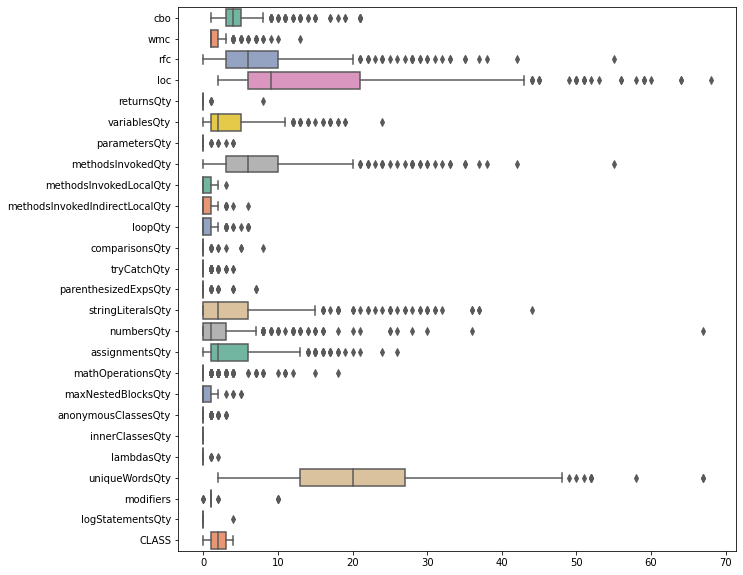

In [34]:
# Boxplot de todo o dataset
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

In [35]:
# Outliers imputation tecnique utilizando outliers do boxplot
def imputation():
    for column in allColumnsWithoutLabel:
        remove_out = np.where(np.in1d(dataset[column], 
                                    boxplot_stats(dataset[column]).pop(0)['fliers']))
        dataset.loc[remove_out[0], column] = dataset[column].mean()

# Imputation Luana
def imputation2():
    for column in allColumnsWithoutLabel:
        outliers_index_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        q3 = dataset[column].quantile(0.9)
        q1 = dataset[column].quantile(0.1)
        print(q3)
        print(q1)
        for i in outliers_index_list[0]:
            instance_value = dataset[column].loc[i]
            if instance_value > q3:
                print(instance_value, "to", q3)
                dataset[column] = dataset[column].replace(instance_value, q3)
            if instance_value < q1:
                dataset[column] = dataset[column].replace(instance_value, q1)

# Imputation considerando substituição de maximo e minimo nos outliers
def imputation3():
    for column in allColumnsWithoutLabel:
        index = 0
        count = 0
        mean = 0

        outliers_list = np.where(np.in1d(dataset[column], boxplot_stats(dataset[column]).pop(0)['fliers']))
        datasetWithoutOutliers = dataset.drop(dataset.index[[outliers_list[0]]])
        maxValue = datasetWithoutOutliers[column].max() - 1
        minValue = datasetWithoutOutliers[column].min() + 1
        for i in outliers_list[0]:
            instanceValue = dataset.loc[i, column]
            if(instanceValue > maxValue):
                dataset.loc[i, column] = maxValue
            elif(instanceValue < minValue):
                dataset.loc[i, column] = minValue

In [36]:
# Aplicando Imputation
imputation3()

/home/luana-martins/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [37]:
# Estas são as métricas que não estão totalmente balanceadas, por isso acabei removendo, dependendo podemos substituir por outras
dataset = dataset.drop(['comparisonsQty'], axis=1)
dataset = dataset.drop(['parenthesizedExpsQty'], axis=1)
dataset = dataset.drop(['lambdasQty'], axis=1)

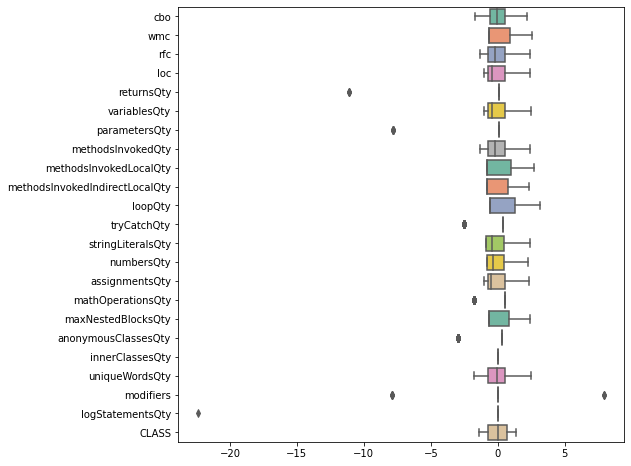

In [38]:
# Normalizando dataset e plotando boxplot novamente
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler().fit(dataset)
scaler = StandardScaler().fit(dataset)
norm_subset = pd.DataFrame(scaler.transform(dataset), columns = dataset.columns)
a = round(norm_subset.describe(), 2)

fig, ax = plt.subplots(figsize=(8,8)) 
ax = sns.boxplot(data=norm_subset, orient="h", palette="Set2")

[Text(0.5, 0, 'cbo'),
 Text(1.5, 0, 'wmc'),
 Text(2.5, 0, 'dit'),
 Text(3.5, 0, 'rfc'),
 Text(4.5, 0, 'lcom'),
 Text(5.5, 0, 'totalMethodsQty'),
 Text(6.5, 0, 'totalFieldsQty'),
 Text(7.5, 0, 'returnQty'),
 Text(8.5, 0, 'loopQty'),
 Text(9.5, 0, 'stringLiteralsQty'),
 Text(10.5, 0, 'loc'),
 Text(11.5, 0, 'assignmentsQty'),
 Text(12.5, 0, 'variablesQty'),
 Text(13.5, 0, 'maxNestedBlocksQty'),
 Text(14.5, 0, 'uniqueWordsQty'),
 Text(15.5, 0, 'CLASS')]

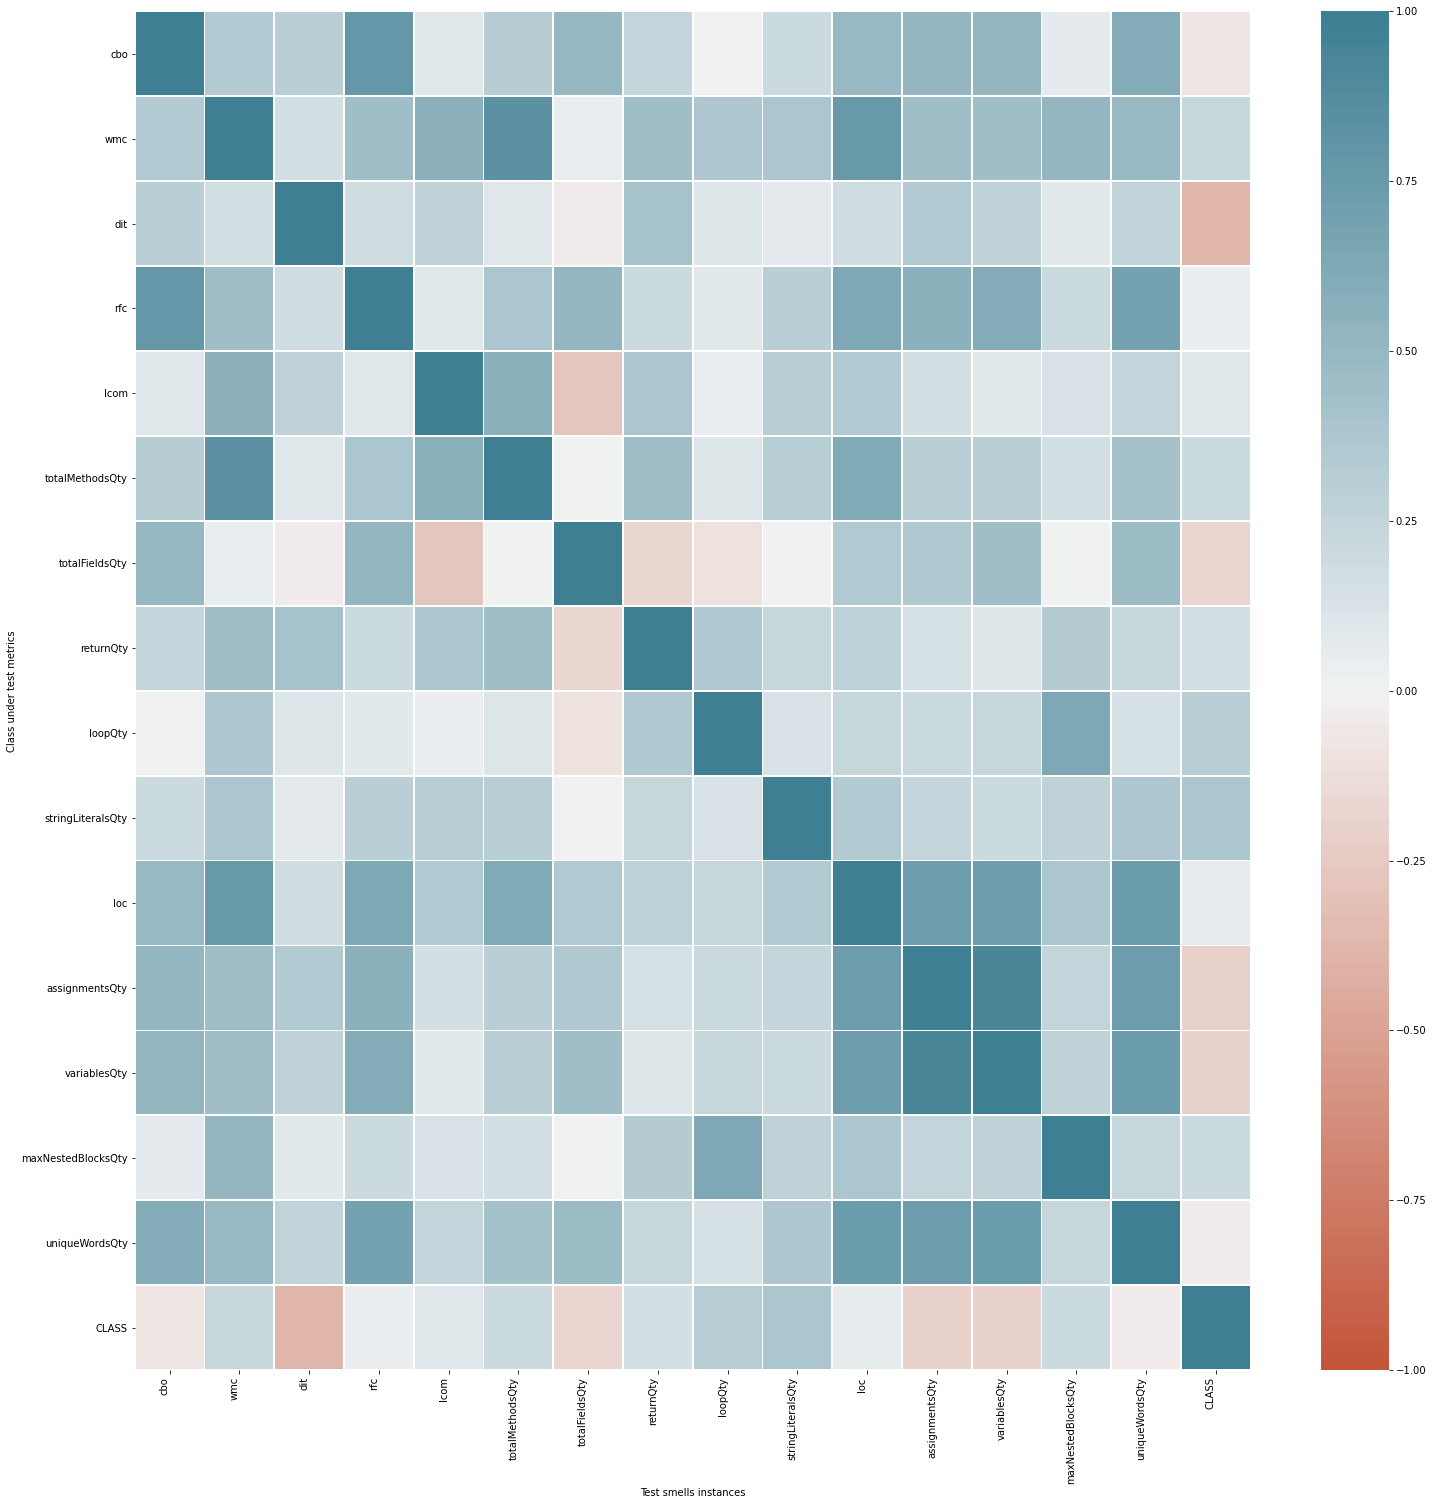

In [10]:
# Só vendo as correlações
#corr = norm_subset.corr(method='spearman').iloc[0:42, 42:]
corr = dataset.corr(method='spearman')

fig, ax = plt.subplots(figsize=(25,25))
    
ax = sns.heatmap(
    corr, 
    linewidths=.8,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=False
)
plt.ylabel('Test class metrics')
plt.xlabel('Test smells instances')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

# Separando dataset para treinamento e teste

In [11]:
# Atualizando classe dos dados normalizados com a classe original
norm_subset["CLASS"] = dataset["CLASS"]

In [52]:
# Dividindo o dataset para treinamento
class_column = norm_subset['CLASS']
norm_subset = norm_subset.drop(['CLASS'], axis = 1)
X_train,X_test,y_train,y_test = train_test_split(norm_subset, class_column, test_size=0.1, random_state=23, 
                                                 stratify=class_column, shuffle=True)

# Escolhendo os melhores parâmetros

## KNN

In [56]:
from sklearn.model_selection import GridSearchCV

# Criando um novo modelo KNN
knn = KNeighborsClassifier()
# Dicionario contendo o parametro que queremos testar (utilizando metricas para valores reais)
param_grid = {'n_neighbors': np.arange(1, 25), 'metric': ['euclidean', 'manhattan', 'chebyshev']}
#Gridsearch para testar o melhor valor para o parametro
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_train, y_train)

knn_gscv.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

# Aplicando algoritmos de classificação

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [24]:
lazy = KNeighborsClassifier(n_neighbors = 3, weights="distance", metric="euclidean")

In [25]:
lazy.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [26]:
lazy.score(X_test, y_test)

0.92

logistic: media 0.768889 | DP 0.052775
knn: media 0.822222 | DP 0.052587
tree: media 0.882222 | DP 0.047713
svm: media 0.835556 | DP 0.043546
dwnn: media 0.893333 | DP 0.050479


[Text(0, 0, 'logistic'),
 Text(0, 0, 'knn'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'svm'),
 Text(0, 0, 'dwnn')]

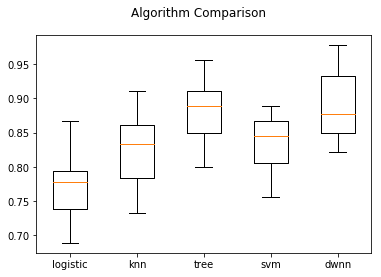

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Preparando os modelos
kfold = model_selection.KFold(n_splits=10, random_state=23)
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = KNeighborsClassifier(n_neighbors = 3, metric="euclidean")
estimators.append(('knn', model2))
model3 = DecisionTreeClassifier()
estimators.append(('tree', model3))
model4 = SVC()
estimators.append(('svm', model4))
model5 = KNeighborsClassifier(n_neighbors = 3, weights="distance", metric="euclidean")
estimators.append(('dwnn', model5))

#ensemble = VotingClassifier(estimators)
#results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)

# Verificando score de todos so modelos
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=23)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    print("%s: media %f | DP %f" % (name, cv_results.mean(), cv_results.std()))

# Plotando boxplot dos resultados
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)